# Libraries

In [1]:
using Revise

## Algorithms

In [2]:
using DifferentialEquations
using Optim
using Statistics
using Distances
using LatinHypercubeSampling

## Data

In [3]:
using CSV
using DataFrames
using DataFramesMeta
using IterTools

## Plotting

In [4]:
using Plots
gr()

Plots.GRBackend()

## Progress

In [5]:
using ProgressMeter

In [6]:
ProgressMeter.ijulia_behavior(:clear)

false

# Functions
`includet` is `Revise.jl`'s change-tracking include

In [7]:
includet("models/base.jl")
includet("models/nsc_kalamakis.jl")

The `base.jl` file implements some types and methods for ease of use of these models.
Namely we have the following types:

- `ModelData` contains a representation of the data (timepoints, weights, fields and values). Offers an implementation of `DataFrame` to return it to a `DataFrame` and offers a constructor from `DataFrame`
- `AbstractModels`s provide a general-purpose interface for some types of models. Namely, a `simulate` can be defined that produces outputs. A relationship between simulation outputs and data can be defined through a series of `link` functions.
- `ODEModel`s are the core of this. They describe initial value problems by implementing a `simulate` which requires a `ratefun` that returns a rate function as well as a `initial` that computes initial values for initial value problems. A sample implementation is in `nsc_kalamakis.jl`
- `ModelObjective` consists of an `AbstractModel` and a `ModelData`. It is a functor that evaluates the objective function as weighted euclidean distance between values and simulations. Also offers several `optimize` methods (picking values from a latin hypercube, using a matrix of starting values or a vector)
- `ModelFit` describes the results of the optimisation. Offers a constructor from `ModelObjective` for ease-of-use, as well as `residuals` and `AIC`.

Basic plot recipes are offered for `ModelData` and `ModelFit`.

# Config
Here we define some fixed properties about our model: what times to solve in and what fixed values we have.

In [8]:
tmin = 0.0
tmax = 700.0
tspan = (tmin, tmax)
pₛ = log(2)*(24/17.5)#0.95

0.9506018476250678

# Data

In [9]:
data = map(["wt", "ifnko"]) do geno
    active = @linq CSV.read("data/data_$(geno)_active.csv", DataFrame) |>
        transform(:name="active") |>
        select(:genotype=:genotype, :time=:age, :name=:name, :value=:active, :weight=:weight)
    counts = @linq CSV.read("data/data_$(geno)_counts.csv", DataFrame) |>
        transform(:name="total") |>
        select(:genotype=:genotype, :time=:age, :name=:name, :value=:count, :weight=:weight)
    vcat([active, counts]...)
end
data = vcat(data...)
data = @linq data |> transform(:field=[n .== "active" ? 2 : 1 for n in :name])

,genotype,time,name,value,weight,field
,String7,Int64,String,Float64,Float64,Int64
1,wt,660,active,0.234043,676.37,2
2,wt,660,active,0.15,676.37,2
3,wt,660,active,0.2,676.37,2
4,wt,660,active,0.228571,676.37,2
5,wt,60,active,0.586207,42.1492,2
6,wt,60,active,0.467742,42.1492,2
7,wt,60,active,0.280702,42.1492,2
8,wt,60,total,764.0,1.97304e-5,1
9,wt,60,total,755.5,1.97304e-5,1


# Setup for optimisation 

## Data

For descriptions of `ModelData` see the included `base.jl` file.

In [10]:
genotypes = Dict(:wt => ModelData(@subset(data, :genotype .== "wt")),
                 :ko => ModelData(@subset(data, :genotype .== "ifnko")))

Dict{Symbol, ModelData} with 2 entries:
  :wt => ModelData([0.234043, 0.15, 0.2, 0.228571, 0.586207, 0.467742, 0.280702…
  :ko => ModelData([0.392857, 0.428571, 0.35, 0.333333, 0.352941, 0.340909, 584…

### Plot without any fits

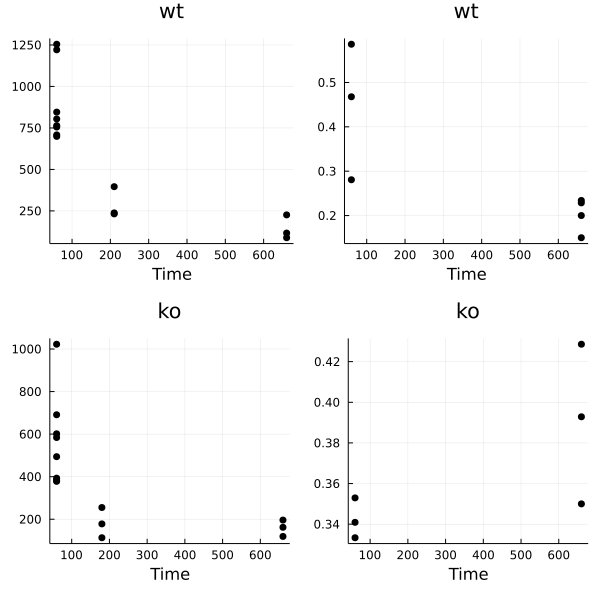

In [11]:
plot([plot(p, title=k) for (k, p) in genotypes]..., layout=@layout([a; b]), size=(600, 600))

## Models to fit

We consider our models as edge cases of the full model with combinations of $\beta$ values set to zero (indicating no change in the relevant parameter function over time)

In [12]:
models = Dict(
    :both       => KalamakisFull(tspan, Dict(:pₛ => pₛ)),
    :self       => KalamakisFull(tspan, Dict(:pₛ => pₛ, :βr => 0.0)),
    :activation => KalamakisFull(tspan, Dict(:pₛ => pₛ, :βb => 0.0)),
    :noageing   => KalamakisFull(tspan, Dict(:pₛ => pₛ, :βb => 0.0, :βr => 0.0)),
)

Dict{Symbol, KalamakisFull} with 4 entries:
  :both       => KalamakisFull((0.0, 700.0), [6=>0.950602])
  :activation => KalamakisFull((0.0, 700.0), [5=>0.0, 6=>0.950602])
  :noageing   => KalamakisFull((0.0, 700.0), [5=>0.0, 3=>0.0, 6=>0.950602])
  :self       => KalamakisFull((0.0, 700.0), [3=>0.0, 6=>0.950602])

## Fit

Keep in mind that this can change with changed initial values.
This `ModelFit` implementation uses multi-start optimisation with a box-bounded Nelder-Mead optimiser.

In [13]:
results = map(IterTools.product(keys(genotypes), keys(models))) do (genotype_name, model_name)
    mo = ModelObjective(genotypes[genotype_name], models[model_name])
    (genotype_name, model_name) => ModelFit(mo, n=28)
end

Iterations: 1598 	 Time: 0:00:00


2×4 Matrix{Pair{Tuple{Symbol, Symbol}, ModelFit}}:
 (:wt, :both)=>ModelFit(ModelObjective(ModelData([0.234043, 0.15, 0.2, 0.228571, 0.586207, 0.467742, 0.280702, 764.0, 755.5, 1254.5  …  708.0, 1221.0, 804.0, 699.0, 232.0, 396.0, 238.0, 116.333, 88.3333, 226.0], [660.0, 660.0, 660.0, 660.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0  …  60.0, 60.0, 60.0, 60.0, 210.0, 210.0, 210.0, 660.0, 660.0, 660.0], [2, 2, 2, 2, 2, 2, 2, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [676.37, 676.37, 676.37, 676.37, 42.1492, 42.1492, 42.1492, 1.97304e-5, 1.97304e-5, 1.97304e-5  …  1.97304e-5, 1.97304e-5, 1.97304e-5, 1.97304e-5, 0.000115616, 0.000115616, 0.000115616, 0.0001889, 0.0001889, 0.0001889]), KalamakisFull((0.0, 700.0), [6=>0.950602])), Optim.MultivariateOptimizationResults{Fminbox{NelderMead{Optim.AffineSimplexer, Optim.AdaptiveParameters}, Float64, Optim.var"#47#49"}, Vector{Float64}, Float64, Float64, Vector{OptimizationState{Float64, NelderMead{Optim.AffineSimplexer, Optim.AdaptiveParameters}}}, Not

In [14]:
results_dict = Dict(results[:]...)

Dict{Tuple{Symbol, Symbol}, ModelFit} with 8 entries:
  (:ko, :activation) => ModelFit(ModelObjective(ModelData([0.392857, 0.428571, …
  (:ko, :noageing)   => ModelFit(ModelObjective(ModelData([0.392857, 0.428571, …
  (:ko, :self)       => ModelFit(ModelObjective(ModelData([0.392857, 0.428571, …
  (:wt, :noageing)   => ModelFit(ModelObjective(ModelData([0.234043, 0.15, 0.2,…
  (:wt, :activation) => ModelFit(ModelObjective(ModelData([0.234043, 0.15, 0.2,…
  (:wt, :both)       => ModelFit(ModelObjective(ModelData([0.234043, 0.15, 0.2,…
  (:ko, :both)       => ModelFit(ModelObjective(ModelData([0.392857, 0.428571, …
  (:wt, :self)       => ModelFit(ModelObjective(ModelData([0.234043, 0.15, 0.2,…

# Fit results 

## Overview plots

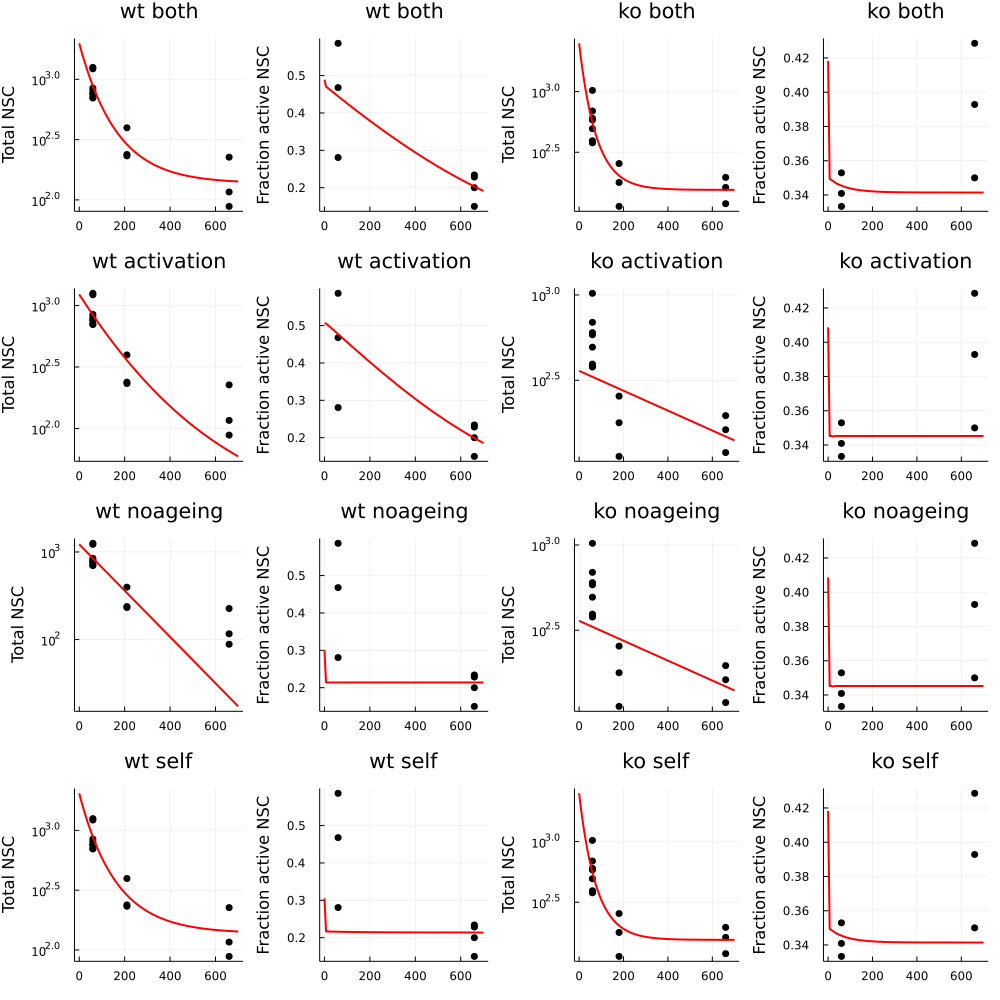

In [15]:
plot(map(x -> plot(x.second, title="$(x.first[1]) $(x.first[2])"), results)..., layout=(4, 2), size=(1000, 1000))

In [16]:
Dict(k => parameter_dict(x) for (k, x) in results_dict)

Dict{Tuple{Symbol, Symbol}, Dict{Symbol, Float64}} with 8 entries:
  (:ko, :activation) => Dict(:βb=>0.0, :b₀=>0.497955, :βr=>9.99854e-11, :r₀=>0.…
  (:ko, :noageing)   => Dict(:βb=>0.0, :b₀=>0.497955, :βr=>0.0, :r₀=>0.50055, :…
  (:ko, :self)       => Dict(:βb=>0.012858, :b₀=>0.445656, :βr=>0.0, :r₀=>0.492…
  (:wt, :noageing)   => Dict(:βb=>0.0, :b₀=>0.485069, :βr=>0.0, :r₀=>0.257068, …
  (:wt, :activation) => Dict(:βb=>0.0, :b₀=>0.493186, :βr=>0.00216099, :r₀=>0.9…
  (:wt, :both)       => Dict(:βb=>0.00486386, :b₀=>0.482138, :βr=>0.00188745, :…
  (:ko, :both)       => Dict(:βb=>0.0128581, :b₀=>0.445657, :βr=>1.68262e-11, :…
  (:wt, :self)       => Dict(:βb=>0.00613459, :b₀=>0.459648, :βr=>0.0, :r₀=>0.2…

## Table with all estimates

In [17]:
params = DataFrame(collect(hcat([parameter_array(x) for x in values(results_dict)]...)'), parameter_names(KalamakisFull))
params[!, :genotype] = [k[1] for k in keys(results_dict)]
params[!, :model] = [k[2] for k in keys(results_dict)]
params[!, :r_w] = [residuals(results_dict[k]) for k in keys(results_dict)]
params[!, :aicc] = [AIC(results_dict[k]) for k in keys(results_dict)]
order = vcat([:genotype, :model, :r_w, :aicc, :Δaicc], parameter_names(KalamakisFull))
params = @linq params |>
    orderby(:genotype, :aicc) |>
    DataFramesMeta.groupby(:genotype) |>
    transform(:Δaicc=:aicc .- :aicc[1]) |>
    orderby(:genotype, :Δaicc)
ENV["COLUMNS"] = 160
params[!,order]

,genotype,model,r_w,aicc,Δaicc,nsc₀,r₀,βr,b₀,βb,pₛ
,Symbol,Symbol,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,ko,self,4.50346,-19.1511,0.0,2500.0,0.492854,0.0,0.445656,0.012858,0.950602
2,ko,noageing,5.91178,-16.8757,2.27537,358.843,0.50055,0.0,0.497955,0.0,0.950602
3,ko,both,4.50346,-15.532,3.61905,2500.0,0.492849,1.68262e-11,0.445657,0.0128581,0.950602
4,ko,activation,5.91178,-13.709,5.44203,358.845,0.50055,9.99854e-11,0.497955,0.0,0.950602
5,wt,activation,4.64892,-21.1656,0.0,1229.12,0.979359,0.00216099,0.493186,0.0,0.950602
6,wt,both,4.0,-20.8228,0.342852,1987.51,0.840994,0.00188745,0.482138,0.00486386,0.950602
7,wt,self,4.78973,-20.539,0.626641,2041.87,0.258614,0.0,0.459648,0.00613459,0.950602
8,wt,noageing,5.70473,-19.956,1.20966,1222.15,0.257068,0.0,0.485069,0.0,0.950602


## No ageing

nsc₀: 1222.1529672374036
r₀: 0.25706782656569993
βr: 0.0
b₀: 0.48506881439868793
βb: 0.0
pₛ: 0.9506018476250678
r_w: 5.704733297940834


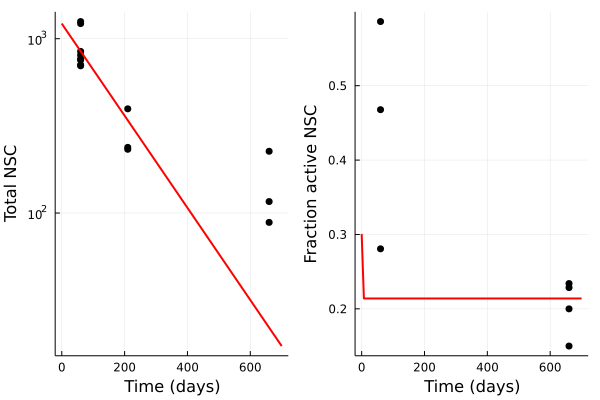

In [18]:
r = results_dict[:wt, :noageing]
parms = parameter_dict(r)
for k  in parameter_names(KalamakisFull)
    println("$k: $(parms[k])")
end
println("r_w: $(r.obj(r.best))")
plot(r, xlabel="Time (days)")

nsc₀: 358.8431066538936
r₀: 0.500549599702293
βr: 0.0
b₀: 0.49795466510949804
βb: 0.0
pₛ: 0.9506018476250678
r_w: 5.91177849004104


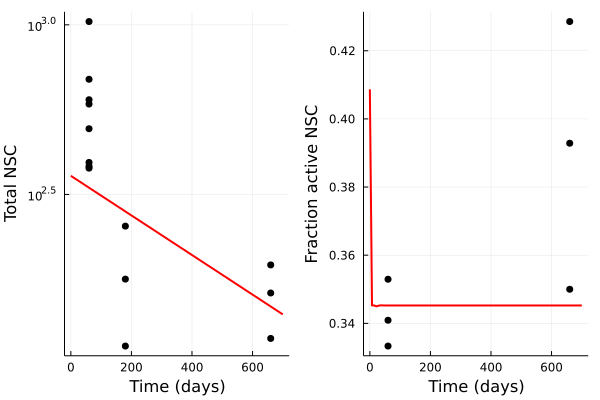

In [19]:
r = results_dict[:ko, :noageing]
parms = parameter_dict(r)
for k  in parameter_names(KalamakisFull)
    println("$k: $(parms[k])")
end
println("r_w: $(r.obj(r.best))")
plot(r, xlabel="Time (days)")

## Activation changes

nsc₀: 1229.1228414789525
r₀: 0.9793589190061914
βr: 0.002160987835838392
b₀: 0.49318555231636835
βb: 0.0
pₛ: 0.9506018476250678
r_w: 4.648919207552961


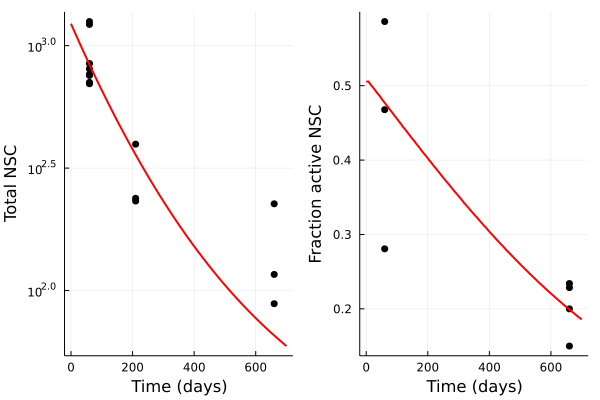

In [20]:
r = results_dict[:wt, :activation]
parms = parameter_dict(r)
for k  in parameter_names(KalamakisFull)
    println("$k: $(parms[k])")
end
println("r_w: $(r.obj(r.best))")
plot(r, xlabel="Time (days)")

nsc₀: 358.84547161232916
r₀: 0.5005496044172378
βr: 9.998540287339075e-11
b₀: 0.49795470706349654
βb: 0.0
pₛ: 0.9506018476250678
r_w: 5.911778689793189


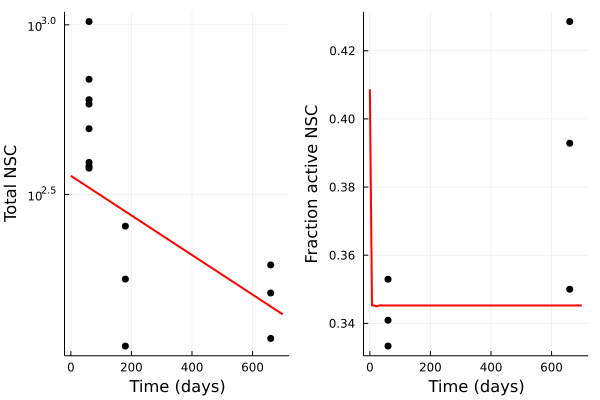

In [21]:
r = results_dict[:ko, :activation]
parms = parameter_dict(r)
for k  in parameter_names(KalamakisFull)
    println("$k: $(parms[k])")
end
println("r_w: $(r.obj(r.best))")
plot(r, xlabel="Time (days)")

## Self-renewal

nsc₀: 2041.8650055989788
r₀: 0.2586144352138671
βr: 0.0
b₀: 0.4596484278089199
βb: 0.006134585640893647
pₛ: 0.9506018476250678
r_w: 4.789733573869274


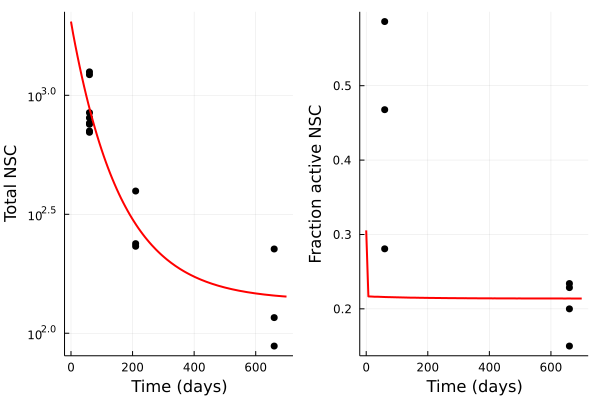

In [22]:
r = results_dict[:wt, :self]
parms = parameter_dict(r)
for k  in parameter_names(KalamakisFull)
    println("$k: $(parms[k])")
end
println("r_w: $(r.obj(r.best))")
plot(r, xlabel="Time (days)")

nsc₀: 2499.9999411533468
r₀: 0.49285418192327224
βr: 0.0
b₀: 0.4456556394069573
βb: 0.012858030232741579
pₛ: 0.9506018476250678
r_w: 4.50345584649707


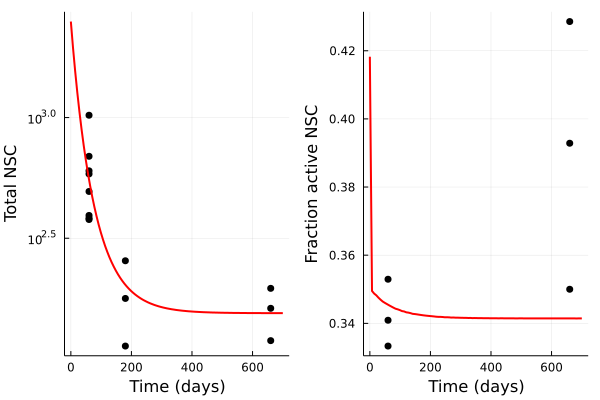

In [23]:
r = results_dict[:ko, :self]
parms = parameter_dict(r)
for k  in parameter_names(KalamakisFull)
    println("$k: $(parms[k])")
end
println("r_w: $(r.obj(r.best))")
plot(r, xlabel="Time (days)")

## Both

nsc₀: 1987.5083018193732
r₀: 0.8409938344975819
βr: 0.0018874514640146137
b₀: 0.48213762124829157
βb: 0.004863855889607077
pₛ: 0.9506018476250678
r_w: 4.000000001405809


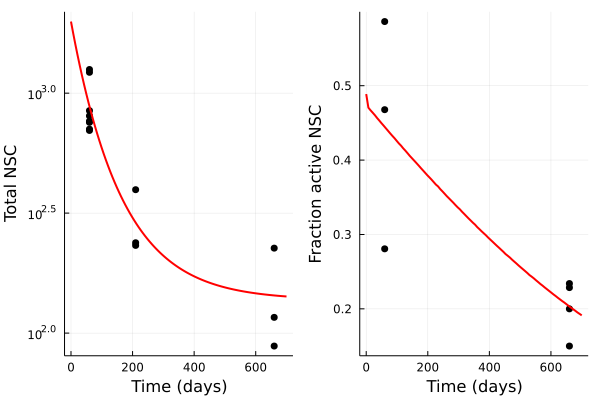

In [24]:
r = results_dict[:wt, :both]
parms = parameter_dict(r)
for k  in parameter_names(KalamakisFull)
    println("$k: $(parms[k])")
end
println("r_w: $(r.obj(r.best))")
plot(r, xlabel="Time (days)")

nsc₀: 2499.999839135833
r₀: 0.4928493423508927
βr: 1.6826172037507e-11
b₀: 0.4456568328759855
βb: 0.012858092899931608
pₛ: 0.9506018476250678
r_w: 4.503456173878154


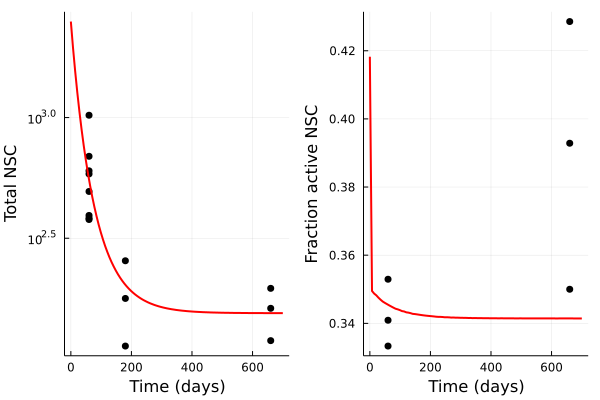

In [25]:
r = results_dict[:ko, :both]
parms = parameter_dict(r)
for k  in parameter_names(KalamakisFull)
    println("$k: $(parms[k])")
end
println("r_w: $(r.obj(r.best))")
plot(r, xlabel="Time (days)")

# Package versions

In [26]:
pkgs = IOBuffer()
loaded = Base.loaded_modules_array()
using Pkg; Pkg.status(io=pkgs)
seek(pkgs, 0)
pkgs = split(String(read(pkgs)), "\n")
for pkg in pkgs
    if any([contains(pkg, "$l") for l in loaded])
        println(pkg)
    end
end

  [336ed68f] CSV v0.9.11
  [8be319e6] Chain v0.4.8
  [944b1d66] CodecZlib v0.7.0
  [a93c6f00] DataFrames v1.2.2
  [1313f7d8] DataFramesMeta v0.10.0
  [864edb3b] DataStructures v0.18.10
  [0c46a032] DifferentialEquations v6.20.0
  [b4f34e82] Distances v0.10.7
  [31c24e10] Distributions v0.25.34
  [c87230d0] FFMPEG v0.4.1
  [08572546] FlameGraphs v0.2.9
  [f6369f11] ForwardDiff v0.10.23
  [7073ff75] IJulia v1.23.2
  [c8e1da08] IterTools v1.4.0
  [a5e1c1ea] LatinHypercubeSampling v1.6.4
  [fefb7f33] MetaPlots v0.1.0 `../../../../../mnt/o/jooa/code.2021-02-03.metaplots.jl#master`
  [429524aa] Optim v1.5.0
  [3b7a836e] PGFPlots v3.4.1
  [91a5bcdd] Plots v1.25.0
  [4391764f] ProfileVega v1.1.1
  [92933f4c] ProgressMeter v1.7.1
  [295af30f] Revise v3.1.20
  [2913bbd2] StatsBase v0.33.13
  [f3b207a7] StatsPlots v0.14.29
  [10745b16] Statistics
